## Setup

In [36]:
## NOTE -- when installing these packages you will have to enter a 'y' to continue with the installation once. So don't start this cell and leave it expecting to finish on its own.
## Recommended to run under CUDA 
!pip install MulticoreTSNE
!wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh && bash Anaconda3-5.2.0-Linux-x86_64.sh -bfp /usr/local
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
!conda install tsnecuda cuda101 -c cannylab

--2020-02-24 20:48:06--  https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 651745206 (622M) [application/x-sh]
Saving to: ‘Anaconda3-5.2.0-Linux-x86_64.sh.2’

Anaconda3-5.2.0-Lin 100%[===================>] 621.55M   120MB/s    in 5.8s    

2020-02-24 20:48:12 (108 MB/s) - ‘Anaconda3-5.2.0-Linux-x86_64.sh.2’ saved [651745206/651745206]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: blas-1.0-mkl ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: intel-openmp-2018.0.0-8 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libgfortran-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: bzip2-1

In [106]:
import requests
import gzip
import zipfile
from os import path
import numpy as np
from gensim.models import KeyedVectors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
import copy
import re
import sklearn.manifold as man
from MulticoreTSNE import MulticoreTSNE as TSNEMULTICORE
from tsnecuda import TSNE as TSNECUDA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)

Device used:  cuda


In [0]:
# helper function to download the data and pretrained embeddings
def downloadFile(url,filepath) :
    if not path.exists(filepath) :
        with requests.get(url) as r :
            open(filepath, 'wb').write(r.content)
    if filepath[-3:]=='.gz' :
        if not path.exists(filepath[:-3]) :
            with gzip.open(filepath) as gz :
                open(filepath[:-3], 'wb').write(gz.read())
    if filepath[-4:]=='.zip' :
        if not path.exists(filepath[:-4]) :
            with zipfile.ZipFile(filepath,'r') as zp :
                zp.extractall()

In [0]:
#uncomment next one
downloadFile('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz',
             'GoogleNews-vectors-negative300.bin.gz')

In [40]:
W2Vmodel = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',
                                             binary=True)
W2V_dict = {token: token_index for token_index, token in enumerate(W2Vmodel.index2word)} 
W2V_weights = W2Vmodel.vectors

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## t-SNE 

In [0]:
def plot_tsne(X, mapping, method, n_components=2, n_iter=500, n_jobs = None):
    assert method in ['TSNE_CUDA', 'TSNE_MULTICORE', 'TSNE_SKLEARN']
    if method == 'TSNE_CUDA':
      tsne = TSNECUDA(n_components = n_components)
      assert n_components == 2 #method only supports 2 component dim reduction
    elif method == 'TSNE_MULTICORE':
      assert n_jobs is not None # must pass num jobs i.e. num cpu cores 
      tsne = TSNEMULTICORE(n_components = n_components, n_jobs=4)
    elif method == 'TSNE_SKLEARN':
      tsne = man.TSNE(perplexity=30, n_components=n_components, init='pca', n_iter=n_iter)

    fig = plt.figure(figsize=(10,10))
    if n_components == 3:
      ax = fig.gca(projection = '3d')
    else:
      ax = fig.add_subplot(111)
    
    trans = tsne.fit_transform(X)

    coordinates = zip(*trans)
    ax.scatter(*coordinates)

    LABELSIZE = 10
    for i in range(len(trans)):
      if n_components == 2:
        ax.annotate(mapping[i], xy=trans[i], textcoords='data', size = LABELSIZE)
      elif n_components == 3:
        ax.text(*trans[i], mapping[i], size=LABELSIZE)
      else:
        raise Error("Only written to handle 2 or 3 components")

    plt.grid()
    plt.show()

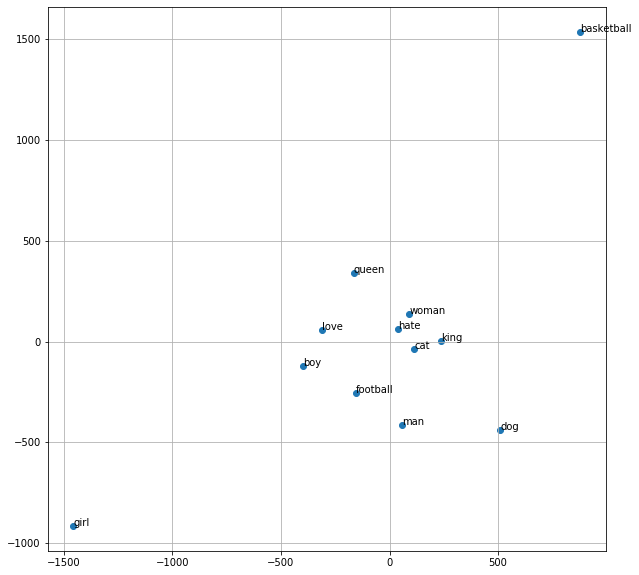

In [154]:
# 2D
# random_sample_indices = np.random.randint(0, len(W2V_weights), 10)
random_sample_indices = [W2V_dict[name] for name in ['girl', 'boy', 'queen', 'king', 'man', 'woman', 'basketball', 'football', 'cat', 'dog', 'love', 'hate']]
subsample_weights = W2V_weights[random_sample_indices]
sub_mapping = [W2Vmodel.index2word[i] for i in random_sample_indices]
plot_tsne(subsample_weights, sub_mapping,'TSNE_CUDA', n_components=2)


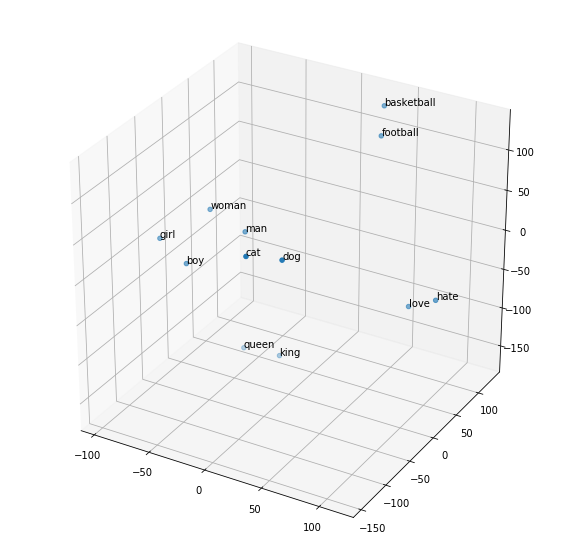

In [155]:
# 3D
# random_sample_indices = np.random.randint(0, len(W2V_weights), 10)
random_sample_indices = [W2V_dict[name] for name in ['girl', 'boy', 'queen', 'king', 'man', 'woman', 'basketball', 'football', 'cat', 'dog', 'love', 'hate']]
subsample_weights = W2V_weights[random_sample_indices]
sub_mapping = [W2Vmodel.index2word[i] for i in random_sample_indices]
plot_tsne(subsample_weights, sub_mapping, 'TSNE_MULTICORE', n_components=3, n_jobs=4)
